### 1 对多个数字进行分类的数据预处理步骤

作者 meelo

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize
from __future__ import print_function

%matplotlib inline

调用linux脚本下载数据集。

In [2]:
%%bash
url=http://ufldl.stanford.edu/housenumbers/
#dataset=train.tar.gz
#dataset=test.tar.gz
dataset=extra.tar.gz
if [ ! -f $dataset ]; then
  wget -q $url$dataset
  tar zxf $dataset
  echo "Successfully download $dataset dataset"
fi


Successfully download extra.tar.gz dataset


训练集大小 33152  
测试集大小 13068  
额外集大小   

In [3]:
#dataset_type = 'train'
#dataset_type = 'test'
dataset_type = 'extra'

In [ ]:
filename = dataset_type + '/digitStruct.mat'
f = h5py.File(filename)

metadata= {}
metadata['height'] = []
metadata['label'] = []
metadata['left'] = []
metadata['top'] = []
metadata['width'] = []

def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(int(obj[0][0]))
    else:
        for k in range(obj.shape[0]):
            vals.append(int(f[obj[k][0]][0][0]))
    metadata[name].append(vals)
    
for item in f['/digitStruct/bbox']:
    f[item[0]].visititems(print_attrs)

In [5]:
data_size = len(metadata['height'])

print('Data size: ', data_size)

Data size:  13068


训练数据集有一个样本的包含6个数字

In [6]:
boxes = np.zeros((data_size, 4), dtype=np.int16)
labels = np.full((data_size, 6), -1, dtype=np.int8)

for i in range(len(metadata['height'])):
    top = 1000000
    bottom = 0
    left = 1000000
    right = 0
    for j in range(len(metadata['height'][i])):
        top = min(top, metadata['top'][i][j])
        left = min(left, metadata['left'][i][j])
        bottom = max(bottom, metadata['top'][i][j]+metadata['height'][i][j])
        right = max(right, metadata['left'][i][j]+metadata['width'][i][j])
    boxes[i] = [max(top,0), max(left,0), bottom, right]
    try:
        labels[i, 0] = len(metadata['label'][i])
        labels[i, 1:1+labels[i, 0]] = metadata['label'][i]
    except:
        labels[i, 1:1+labels[i, 0]] = metadata['label'][i][:5]
        print(metadata['label'][i])
    #train.append([max(top,0), max(left,0), bottom, right, metadata['label'][i]])

In [7]:
labels[:10]

array([[ 1,  5, -1, -1, -1, -1],
       [ 3,  2,  1, 10, -1, -1],
       [ 1,  6, -1, -1, -1, -1],
       [ 1,  1, -1, -1, -1, -1],
       [ 1,  9, -1, -1, -1, -1],
       [ 1,  1, -1, -1, -1, -1],
       [ 3,  1,  8,  3, -1, -1],
       [ 2,  6,  5, -1, -1, -1],
       [ 3,  1,  4,  4, -1, -1],
       [ 2,  1,  6, -1, -1, -1]], dtype=int8)

在数据集中标签10代表数字0，为了方便后续处理，需要将其转换成标签0。  
标签10代表不存在该数字。

In [8]:
labels[labels == 10] = 0
labels[labels == -1] = 10

In [9]:
labels[40:50]

array([[ 2,  2,  8, 10, 10, 10],
       [ 1,  3, 10, 10, 10, 10],
       [ 2,  1,  4, 10, 10, 10],
       [ 4,  1,  7,  1,  2, 10],
       [ 2,  1,  7, 10, 10, 10],
       [ 2,  1,  0, 10, 10, 10],
       [ 2,  1,  4, 10, 10, 10],
       [ 2,  4,  6, 10, 10, 10],
       [ 2,  4,  4, 10, 10, 10],
       [ 2,  2,  8, 10, 10, 10]], dtype=int8)

In [10]:
boxes[:10]

array([[  7,  43,  37,  62],
       [  5,  99,  31, 133],
       [  6,  61,  22,  72],
       [  6,  32,  23,  46],
       [ 28,  97,  56, 116],
       [ 11,  40,  34,  47],
       [  6,  44,  28,  72],
       [ 16,  62,  40,  94],
       [  5,  27,  26,  67],
       [ 19,  16,  40,  38]], dtype=int16)

### 统计数据集中包含数字方框大小的分布

Image shape before resize (31, 23, 3)
Image shape after resize (32, 32, 3)


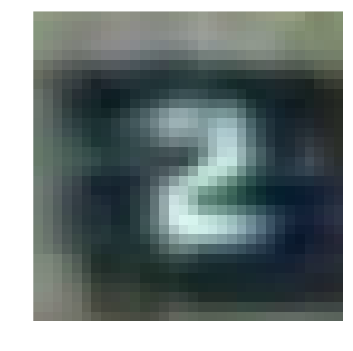

In [11]:
image_index = 91

image = plt.imread(dataset_type + '/{}.png'.format(image_index))
plt.axis('off')
top, left, bottom, right = boxes[image_index-1]
# plt.imshow(image[top:bottom, left:right], interpolation='none')
print ('Image shape before resize', image[top:bottom, left:right].shape)
image_resize = imresize(image[top:bottom, left:right], (32, 32))

plt.imshow(image_resize, interpolation='none')
print ('Image shape after resize', image_resize.shape)

异常值 bbox -1

In [12]:
def gcn(dataset):
    """Global contrast normalization"""
    mean = dataset.mean(axis=(1,2))
    std = dataset.std(axis=(1,2))
    return (dataset - mean[:, None, None]) / std[:, None, None]

In [ ]:
IMAGE_SIZE = 40

In [13]:
import time

dataset = np.zeros((data_size, 32, 32))
for i in range(data_size):
    #time.sleep(0.4)
    
    image = plt.imread(dataset_type + '/{}.png'.format(i+1))
    top, left, bottom, right = boxes[i]
    image = image[top:bottom, left:right]
    #print i, image.shape
    #image = image.mean(axis=2)
    image = np.dot(image, [0.2989, 0.5870, 0.1140])
    #print 'Image shape before resize', image.shape
    #print image.shape
    try:
        image = imresize(image, (IMAGE_SIZE, IMAGE_SIZE))
        dataset[i, :, :] = image
    except:
        print ('Image #{}'.format(i))
        print ('Image shape after resize', image.shape)
        print (top, left, bottom, right)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray, interpolation='none')

In [14]:
dataset = gcn(dataset)

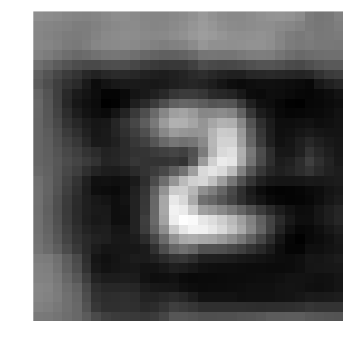

In [15]:
plt.axis('off')
plt.imshow(dataset[90], cmap=plt.cm.gray, interpolation='none')

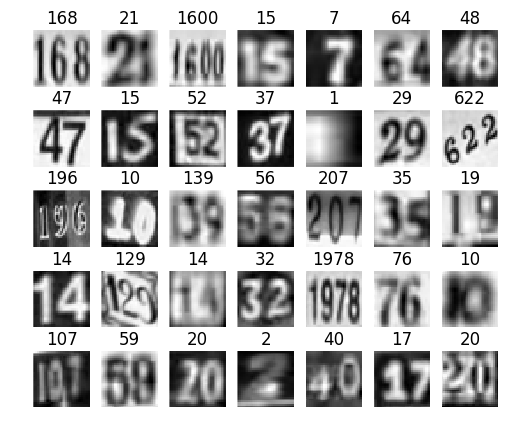

In [16]:
# Make sure image still look good
import random

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(6,5))
for ax in axes.flatten():
    random_idx = random.randint(0, dataset.shape[0]-1)
    ax.axis('off')
    ax.imshow(dataset[random_idx], cmap=plt.cm.gray, interpolation='none')
    ax.set_title( ''.join(map(str, labels[random_idx, 1:1+labels[random_idx,0]])) )

In [17]:
from six.moves import cPickle as pickle

In [18]:
data = {
    'dataset': dataset,
    'labels': labels
}

pickle_file = 'svhn_multi_' + dataset_type + '.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)